In [ ]:
#instalando bibliotecas necessárias para criarmos a RL

!pip install gym==0.24
!pip install pygame
!pip install numpy

!pip install huggingface_hub
!pip install pickle5
!pip install pyyaml==6.0
!pip install imageio
!pip install imageio_ffmpeg
!pip install pyglet==1.5.1
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.4/694.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.0-py3-none-any.whl size=790679 sha256=a8fc2852863b17cc409b633a5720fff7debe17526ea64c57d9426cddf3e00aee
  Stored in directory: /root/.cache/pip/wheels/2f/a1/b1/5f4110c8943b36e6cdfcc0e5768481639fa042b3c8357e82cc
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255312 sha256=a1f7c9296496f8d736eb8e3b2a85a8a2f0fb9d0940ab1d0bc01c98a5825f3ebd
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772b

In [ ]:
#fazendo os imports necessários

import numpy as np
import gym
import random
import imageio
import os
import tqdm
import time
import matplotlib.pyplot as plt

import pickle5 as pickle
from tqdm.notebook import tqdm

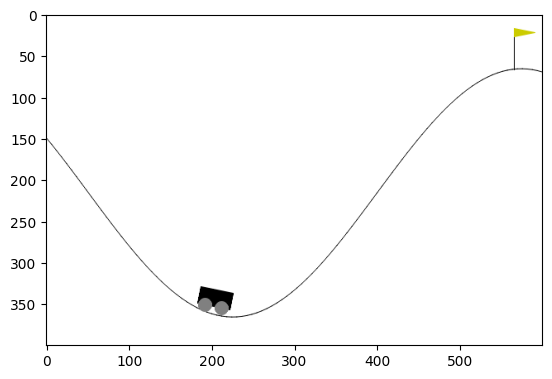

In [ ]:
# plotando a imagem do ambiente do jogo


env = gym.make('MountainCar-v0')

img = env.render(mode='rgb_array')
plt.imshow(img)

In [ ]:
#extraindo informações sobre o ambiente

print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample())

_____OBSERVATION SPACE_____ 

Observation Space Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Sample observation [0.4074436  0.05998963]


In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # pegar um ação qualquer
# Aqui podemos ver que o jogo possui 3 ações para o agente que são: "acelerar para cima" , "acelerar para trás" e nada


 _____ACTION SPACE_____ 

Action Space Shape 3
Action Space Sample 0


In [ ]:
# Vamos criar nossa Qtable de tamanho (state_space, action_space) e inicializar cada valor em 0 usando np.zeros
# nossa Q-table vai ter ações como colunas e estados como linhas, logo vai ser uma 3x2, pois tem 3 ações e o ambiente tem 2 estados possíveis
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [ ]:

state_space = env.observation_space.shape[0]
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  2  possible states
There are  3  possible actions


In [ ]:
Qtable= initialize_q_table(state_space, action_space)

In [ ]:
Qtable

array([[0., 0., 0.],
       [0., 0., 0.]])

Assim, achamos nossa Q-table de 3 colunas(ações) e 2 (linhas), entretanto percebemos que não tem como cada possível ação levar apenas a 2 estados possíveis, não faz sentido ter (ação < estados possíveis). Portanto vou separar os intervalo de posição e velocidade em um intervalos de bins para aprimorar o problema
---



In [ ]:
# Função para converter estado contínuo em um índice único, para que possamos acessar esse índice na tabela

def state_to_index(state, state_bins):
    index = 0
    for i, val in enumerate(state):
        bin_index = np.digitize(val, state_bins[i]) - 1

        # Garantir que o índice de bin não seja negativo
        bin_index = max(bin_index, 0)

        index += int(bin_index * np.prod([len(bins) for bins in state_bins[i+1:]]))

    # Garantir que o índice final está dentro dos limites esperados
    if index < 0:
        raise ValueError(f"Índice de estado calculado é negativo: {index}")

    return int(index)


a célula anterior foi a parte mais complicada do código,pois muitas vezes que tentava acessar o índice na Q-table, era me retornado um índice de ponto flutuante ou negativo, que a tabela nunca iria reconhecer, então botei umas validações para evitar esse problema


In [ ]:
#aqui eu separei em bins para discretizar a velocidade e a posição de maneira mais intuitiva
# Se eu quisesse fragmentar em mais bins , como 50 por exemplo ia ter mais informações sobre o modelo

def initialize_q_table(n_position_bins, n_velocity_bins, action_space):
    state_space = n_position_bins * n_velocity_bins
    Qtable = np.zeros((state_space, action_space))
    return Qtable

# 20 bins para posição e 20 bins para velocidade
n_position_bins = 20
n_velocity_bins = 20
action_space = env.action_space.n

Qtable = initialize_q_table(n_position_bins, n_velocity_bins, action_space)


In [ ]:
Qtable

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
Qtable.shape

(400, 3)

Agora, faz muito mais sentido, pois existem 400 estados possiveis e 3 ações para o agente realizar.Assim, usando o formato de bins Cada linha da Q-table representará um estado discretizado, e cada coluna representará uma ação possível, tornando nossa Q-table muito mais completa.

In [ ]:
#vamos definir nossa greedy_policy, que é uma política relacionada a exploration e exploitation
# primeiramente o agente vai priorizar e exploration e comforme o tempo for passando ele vai preferindo o amibente mais seguro possível
#entretanto, vamos definir um valor mínimo de epsilon para ele continuar explorando menos no final mas não cessar a exploração
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state][:])

  return action

In [ ]:
import random

random.seed(50)
np.random.seed(50)

def epsilon_greedy_policy(Qtable, state, epsilon, seed=50):
    # Definir a semente para garantir consistência
    random.seed(seed)

    # Gera aleatoriamente um número entre 0 e 1
    random_int = random.uniform(0, 1)

    # if random_int > epsilon --> exploitation (escolher a melhor ação conhecida)
    if random_int > epsilon:
        action = greedy_policy(Qtable, state)
    else:
        action = env.action_space.sample()  # Escolhe uma ação aleatória

    return action




In [ ]:
# Parâmetros de treinamento
n_training_episodes = 12000  # Aumentei o número de episódios para explorar mais variações no aprendizado
learning_rate = 0.65  # Reduzi um pouco a taxa de aprendizado para ver se a estabilidade melhora ainda mais

# Parâmetros de avaliação
n_eval_episodes = 100  # Mantive o mesmo número de episódios de avaliação

# Parâmetros do ambiente
env_id = "MountainCar-v0"  # Nome do ambiente
max_steps = 2000  # Aumentei o número de passos para dar mais flexibilidade ao carrinho e garantir que ele chegue à bandeira
gamma = 0.93  # Aumentei ligeiramente para incentivar um pouco mais as recompensas futuras, ajudando o carrinho a planejar melhor

# Parâmetros de exploração
max_epsilon = 1.0  # Mantive para permitir alta exploração no início
min_epsilon = 0.02  # Aumentei um pouco a exploração mínima para testar se o agente encontra melhores estratégias ao final
decay_rate = 0.0009  # Ajustei o decaimento para permitir uma transição mais gradual para exploração






In [ ]:
# Função de treinamento
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, state_bins):
    for episode in tqdm(range(n_training_episodes)):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

        # Redefinir o ambiente e converter o estado inicial em um índice único
        state = state_to_index(env.reset(), state_bins)

        # Valide se o estado é um inteiro válido
        if not isinstance(state, int) or state < 0 or state >= Qtable.shape[0]:
            raise ValueError(f"Estado inválido: {state}")

        done = False

        for step in range(max_steps):
            # Escolha a ação At para usar a política epsilon-greedy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Execute a ação  e observe o novo estado e a recompensa
            new_state, reward, done, info = env.step(action)
            new_state = state_to_index(new_state, state_bins)  # Converte o novo estado em um índice único

            # Valide se o novo estado é um inteiro válido
            if not isinstance(new_state, int) or new_state < 0 or new_state >= Qtable.shape[0]:
                raise ValueError(f"Novo estado inválido: {new_state}")

            # Atualiza Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            #parte muito importante,pois atualiza os Q-values com base nas ações e estados atuais
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

            if done:
                break

            state = new_state
    return Qtable



In [ ]:
state_bins = [np.linspace(-1.2, 0.6, n_position_bins), np.linspace(-0.07, 0.07, n_velocity_bins)]

In [ ]:
Qtable = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, state_bins)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [ ]:
Qtable

array([[  0.        ,   0.        ,   0.        ],
       [ -8.83246502,  -8.8042868 ,  -8.77250049],
       [-13.80438381, -13.81505045, -13.69476809],
       ...,
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed, epsilon=0.05):
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()

    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Use a política epsilon-greedy com uma semente fixa
      action = epsilon_greedy_policy(Q, state, epsilon, seed=50)

      # Executa a ação escolhida no ambiente
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state

    episode_rewards.append(total_rewards_ep)

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward


In [ ]:
import imageio
import numpy as np
import random
from PIL import Image

def resize_image(image, block_size=16):
    width, height = image.size
    new_width = (width + block_size - 1) // block_size * block_size
    new_height = (height + block_size - 1) // block_size * block_size
    return image.resize((new_width, new_height))

#mudando o fps para 15, para podermos ver os movimentos do carrinho com maior exatidão
# Gravação de vídeo com semente fixa para o ambiente
def record_video(env, Qtable, out_directory, state_bins, fps=15):
    images = []
    done = False
    state = env.reset(seed=50)  # Semente fixa para garantir reprodutibilidade
    state = state_to_index(state, state_bins)
    img = Image.fromarray(env.render(mode='rgb_array'))
    img = resize_image(img)
    images.append(np.array(img))

    step = 0
    while not done:
        action = np.argmax(Qtable[state][:])
        next_state, reward, done, info = env.step(action)
        state = state_to_index(next_state, state_bins)
        img = Image.fromarray(env.render(mode='rgb_array'))
        img = resize_image(img)
        images.append(np.array(img))
        step += 1

    imageio.mimsave(out_directory, images, fps=fps)

# Caminho do vídeo
video_path = "replay.mp4"

# Gravar o vídeo
record_video(env, Qtable, video_path, state_bins, fps=15)



In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os


# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

mudei o fps para fps=15, para podermos ver o vídeo com maior exatidão.



Para que meu agente conseguisse atravessar a bandeira, troquei alguns parâmetros (taxa de aprendizado, gamma e epsilon)


Taxa de aprendizado(alpha): Ao reduzir o valor para 0.7, o aprendizado ocorre de maneira mais gradual, evitando que o agente oscile muito entre decisões diferentes.

gamma: Ajustar para 0.90 faz com que o agente priorize recompensas a curto prazo

Exploração: Diminuir o valor mínimo de epsilon (min_epsilon = 0.01) e a taxa de decaimento (decay_rate = 0.001) permitirá que o agente explore mais antes de se estabilizar e focar em recompensas mais estáveis




Com isso, agora o modelo possui êxito e o agente após aprender com o ambiente, consegue chegar no final da bandeira.: